In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet



import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

c:\Users\FAH\Documents\GitHub\timeseries_fc\notebooks\timeseries_lib\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
file_path = '../data/store_sales_train.csv'
#df = pd.read_csv(file_path, index_col = "Date", low_memory=False, parse_dates=['Date'])
df = pd.read_csv(file_path, low_memory=False)


### Time Series Analysis and Forecasting with Prophet

In [3]:
# remove closed stores and those with no sales
hol_df = df[(df["Store"] == 262)].copy()
df = df[(df["Open"] != 0) & (df['Sales'] != 0)]

# sales for the store number 1 (StoreType C)
sales = df[df.Store == 262].loc[:, ['Date', 'Sales']]

# reverse to the order: from 2013 to 2015
sales = sales.sort_index(ascending = False)

# to datetime64
sales['Date'] = pd.DatetimeIndex(sales['Date'])
sales.dtypes

Date     datetime64[ns]
Sales             int64
dtype: object

In [4]:
# from the prophet documentation every variables should have specific names
sales = sales.rename(columns = {'Date': 'ds',
                                'Sales': 'y'})
sales.head()

,ds,y
1016356,2013-01-01,17267
1015241,2013-01-02,16964
1014126,2013-01-03,16616
1013011,2013-01-04,16849
1011896,2013-01-05,14868


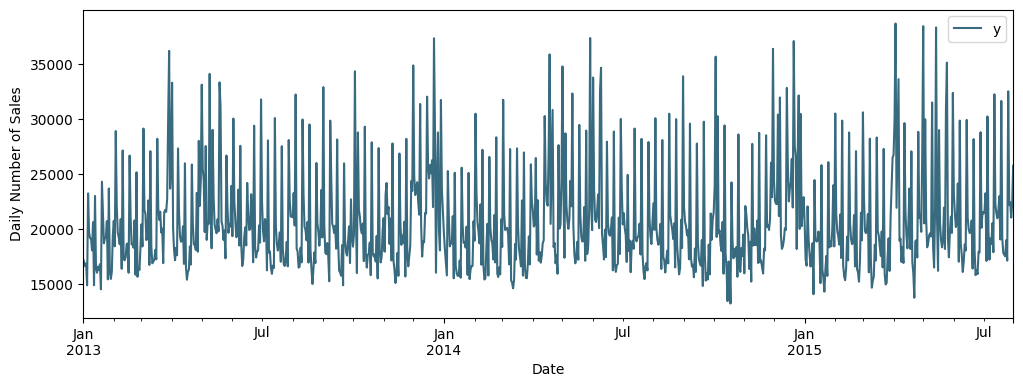

In [5]:
# plot daily sales
c = '#386B7F'
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Daily Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [6]:
# create holidays dataframe
state_dates = hol_df[
    (hol_df["Store"] == 262) & 
    (hol_df["StateHoliday"].isin(['a', 'b', 'c']))
]['Date'].values
school_dates = df[(df["Store"] == 262) & (df.SchoolHoliday == 1)].loc[:, 'Date'].values


state = pd.DataFrame({'holiday': 'state_holiday',
                      'ds': pd.to_datetime(state_dates)})
school = pd.DataFrame({'holiday': 'school_holiday',
                      'ds': pd.to_datetime(school_dates)})

holidays = pd.concat((state, school))      
holidays.head()

,holiday,ds
0,state_holiday,2015-05-25
1,state_holiday,2015-05-14
2,state_holiday,2015-05-01
3,state_holiday,2015-04-06
4,state_holiday,2015-04-03


In [7]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

08:43:41 - cmdstanpy - INFO - Chain [1] start processing
08:43:41 - cmdstanpy - INFO - Chain [1] done processing


First week to forecast.


,ds
977,2015-09-05
978,2015-09-06
979,2015-09-07
980,2015-09-08
981,2015-09-09
982,2015-09-10
983,2015-09-11


In [8]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
977,2015-09-05,17558.274847,13118.466783,22370.426325
978,2015-09-06,28365.414823,23604.352417,33069.143511
979,2015-09-07,19939.766345,15769.531969,24733.690918
980,2015-09-08,18504.584431,13999.611534,23040.809186
981,2015-09-09,18129.811990,13920.934307,22460.043108
982,2015-09-10,18598.273948,13666.932953,22716.680886
983,2015-09-11,20222.723866,15472.284029,24472.962551


In [9]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

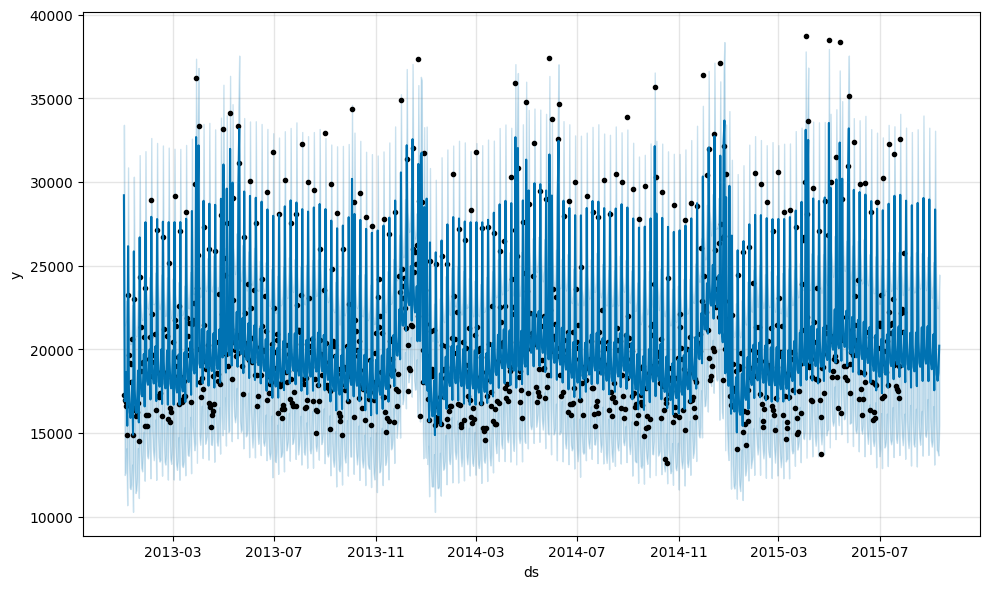

In [10]:
# visualizing predicions
my_model.plot(forecast);

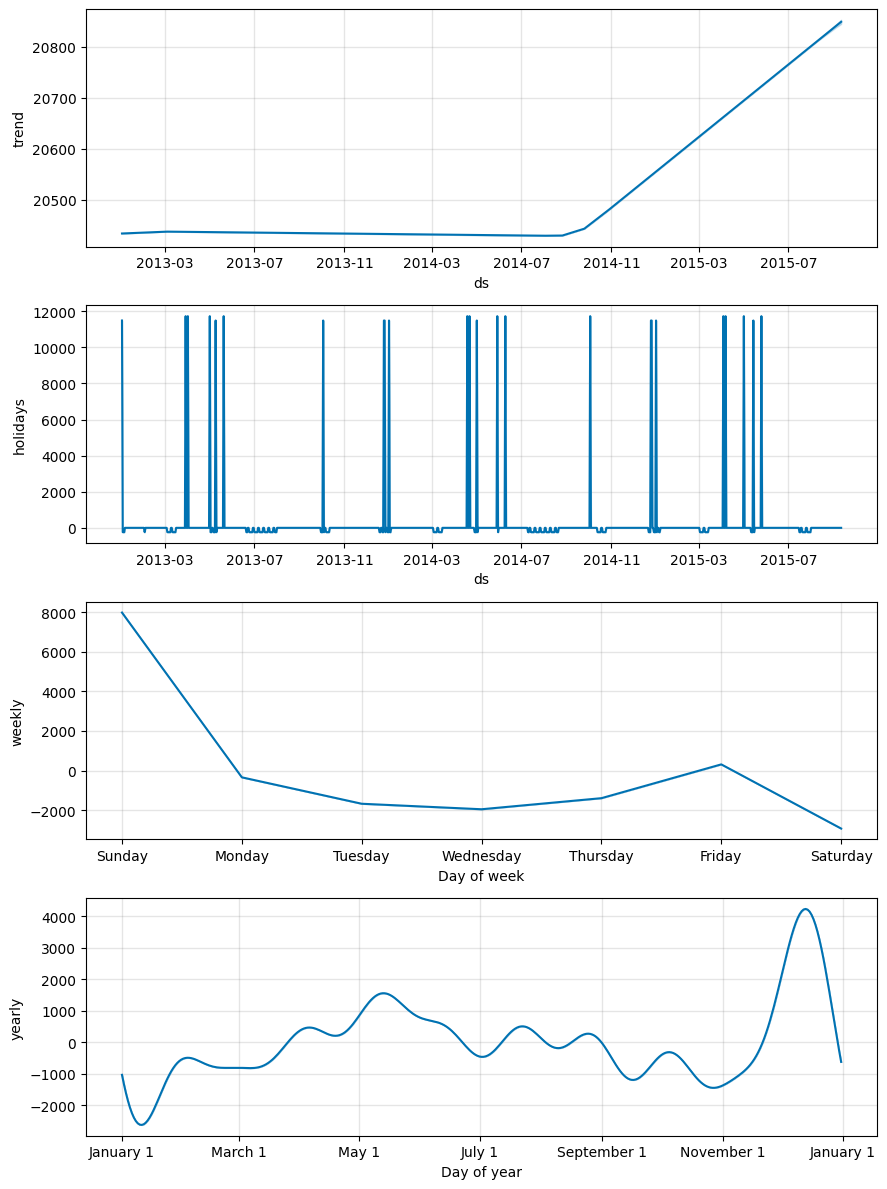

In [11]:
my_model.plot_components(forecast);

In [12]:
MAPE = np.mean(np.abs((sales['y'].values - forecast['yhat'][:-42].values) / sales['y'].values)) * 100
print('Mean Absolute Percentage Error (MAPE): %.2f' % MAPE)



Mean Absolute Percentage Error (MAPE): 8.58
